# this is the manuscript for ploting Figure 3 and 4 in the lake ice manuscript

In [1]:
import numpy as np # version '1.20.0'
import xarray as xr # version '0.16.2'
from tqdm import tqdm # version '4.43.0'
import matplotlib.pyplot as plt # version '3.3.2'
import matplotlib as mpl # version '3.3.2'
import cmocean # version '2.0'
import cartopy.crs as ccrs # version '0.18.0'
import cartopy.feature as cf # version '0.18.0'
import glob
import dask.array as da # version '2021.1.1'
import time
from numpy import nan
import seaborn as sns # version '0.11.0'
import pandas as pd # version 1.2.1'
import matplotlib.path as mpath

In [3]:
# setup the dask parallel computing
from dask.distributed import Client
client = Client(scheduler_file= '.../scheduler.json') # the path to the scheduler file
client

Client Scheduler: tcp://203.247.189.224:39429 Dashboard: http://203.247.189.224:8787/status,Cluster Workers: 16 Cores: 576 Memory: 320.00 GB


# 1. define functions

## 1.1 define functions to read in nc files across all the ensemble members
The variables stored in the directories of individual ensemble members ,we use this function to read the data of all the ensemble members into one xarray dataset

In [5]:
def def_process_coords(exceptcv=[]):
    def process_coords(ds, except_coord_vars=exceptcv):
        coord_vars = []
        for v in np.array(ds.coords):
            if not v in except_coord_vars:
                coord_vars += [v]
        for v in np.array(ds.data_vars):
            if not v in except_coord_vars:
                coord_vars += [v]
        return ds.drop(coord_vars)
    return process_coords
#-----------------------------------------------------------------------------------------------------
def read_in(var, exceptcv, domain='lnd/', freq='day_1/', stream='h6', chunks=dict(time=365), ens_s=-20, ens_e=-10):
    ens_dir = "path for the home directory of the whole CESM-LE data"
    histens_names = [member.split('archive/')[1][:-1]
                     for member in sorted(glob.glob(ens_dir + "b.e21.BHIST*LE2*[!old][!tmp]/"))][10:]
    projens_names = [member.split('archive/')[1][:-1] for member in sorted(
        glob.glob(ens_dir + "b.e21.BSSP370*.f09_g17*[!old][!tmp]/"))][10:]
    hist_ncfiles = []
    proj_ncfiles = []
    for i in np.arange(ens_s, ens_e):
        hist_fnames = sorted(glob.glob(
            ens_dir + histens_names[i] + "/" + domain + "proc/tseries/" + freq + "*" + stream + var + "*"))
        proj_fnames = sorted(glob.glob(
            ens_dir + projens_names[i] + "/" + domain + "proc/tseries/" + freq + "*" + stream + var + "*"))
        hist_ncfiles.append(hist_fnames)
        proj_ncfiles.append(proj_fnames)
    ens_numbers = [members.split('LE2-')[1]
                   for members in histens_names][ens_s:ens_e]
    hist_ds = xr.open_mfdataset(hist_ncfiles,
                                chunks=chunks,
                                preprocess=def_process_coords(exceptcv),
                                combine='nested',
                                concat_dim=[[*ens_numbers], 'time'],
                                parallel=True)
    proj_ds = xr.open_mfdataset(proj_ncfiles,
                                chunks=chunks,
                                preprocess=def_process_coords(exceptcv),
                                combine='nested',
                                concat_dim=[[*ens_numbers], 'time'],
                                parallel=True)
    if freq == 'day_1/':
        hist_ds = hist_ds.isel(time=np.arange(1, hist_ds.time.shape[0]))
        proj_ds = proj_ds.isel(time=np.arange(1, proj_ds.time.shape[0]))
        hist_ds['time'] = hist_ds.time.get_index('time').shift(-1, 'D')
        proj_ds['time'] = proj_ds.time.get_index('time').shift(-1, 'D')
    if freq == 'month_1/':
        hist_ds['time'] = hist_ds.time.get_index('time').shift(-1, 'M')
        proj_ds['time'] = proj_ds.time.get_index('time').shift(-1, 'M')
    ens_ds = xr.concat((hist_ds, proj_ds), 'time')
    ens_ds = ens_ds.rename({'concat_dim': 'ensemble'})
    return ens_ds


## 1.2 define functions calculate linear trend along time dimension 

In [6]:
# this function refers code from https://gist.github.com/luke-gregor/4bb5c483b2d111e52413b260311fbe43
def xarray_trend(xarr,taxis = 'time', units = '\u2103'):    
    from scipy import stats
    # getting shapes
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    x = np.arange(xarr[taxis][0],xarr[taxis][-1:] + 1,1)[:,None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    
    # preparing outputs
    out = xarr[:2].mean(taxis)
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = units + ' / ' + taxis
    xarr_slope.values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])
    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p

    return xarr_out

## 1.3 build a mask array transfer lonxlat grid into a sequential order 
please note, not all the grids has lake simulaiton, in the grids without lake simulation, the values are NaN, to reduce the running memory cost, we transfer lonxlat grid into a sequential order and delete those grids without lake simulation, thus improving the computing efficiency

In [9]:
mask_ds = xr.open_mfdataset('.../b.e21.BHISTcmip6.f09_g17.LE2-1231.001.clm2.h2.EFLX_LH_TOT.185001-185912.nc', # randomly read in one clm5 output file to extract information for the coordinates
                        combine = 'by_coords',
                          parallel=True)

In [10]:
ixy = mask_ds.land1d_ixy - 1
ixy['landunit'] = mask_ds.land1d_ityplunit
lake_ixy = ixy.sel(landunit = 5).astype(int).compute()
jxy = mask_ds.land1d_jxy - 1
jxy['landunit'] = mask_ds.land1d_ityplunit
lake_jxy = jxy.sel(landunit = 5).astype(int).compute()
## change lake_ixy lake_jxy coordinate to make it consistent with computation afterwards
lake_ixy['landunit'] = np.arange(lake_ixy.shape[0])
lake_jxy['landunit'] = np.arange(lake_jxy.shape[0])

In [11]:
landunit_idx = mask_ds.landunit
landunit_idx['landunit'] = mask_ds.land1d_ityplunit
lake_idx = landunit_idx.sel(landunit = 5).values

calculate the lake area and make mask to remove antarctic and greenland

In [12]:
pct_lake_ds = xr.open_dataset('.../surfdata_map/surfdata_0.9x1.25_78pfts_CMIP6_simyr1850_c170824.nc')# the surface input data for CLM5
pct_lake = pct_lake_ds.PCT_LAKE / 100
pct_lake = pct_lake.rename({'lsmlat':'lat','lsmlon':'lon'})
pct_lake = pct_lake.where(pct_lake > 0)
pct_lake['lat'] = mask_ds.lat
pct_lake['lon'] = mask_ds.lon

landfrac  = pct_lake_ds.LANDFRAC_PFT
landfrac  = landfrac.rename({'lsmlat':'lat','lsmlon':'lon'})
landfrac['lat'] = mask_ds.lat
landfrac['lon'] = mask_ds.lon

cell_area = pct_lake_ds.AREA
cell_area = cell_area.rename({'lsmlat':'lat','lsmlon':'lon'})
cell_area['lat'] = mask_ds.lat
cell_area['lon'] = mask_ds.lon

In [13]:
## setup mask to remove ocean and ice sheet area
glacier_region = pct_lake_ds.GLACIER_REGION
glacier_region = glacier_region.rename(dict(lsmlat = 'lat', lsmlon = 'lon'))
glacier_region['lat'] = mask_ds.lat
glacier_region['lon'] = mask_ds.lon

landfrac = landfrac.where(glacier_region == 0,0)

pct_lake = pct_lake.where(landfrac > 0)

lake_area = cell_area * landfrac * pct_lake

In [14]:
lake_mask = (pct_lake_ds.PCT_LAKE > 0)
lake_mask = lake_mask.rename({'lsmlat':'lat','lsmlon':'lon'})
lake_mask['lat'] = mask_ds.lat
lake_mask['lon'] = mask_ds.lon
## remove lakes in antarctic and greenland
lake_mask = lake_mask.where(landfrac > 0,False)

In [15]:
lake_area_lunit = lake_area[lake_jxy, lake_ixy]

In [16]:
lake_mask_lunit = lake_mask[lake_jxy, lake_ixy]

In [17]:
lake_ixy = lake_ixy.sel(landunit = lake_mask_lunit)
lake_jxy = lake_jxy.sel(landunit = lake_mask_lunit)
lake_idx = lake_idx[lake_mask_lunit]
lake_area_lunit = lake_area_lunit.sel(landunit = lake_mask_lunit)

In [18]:
lake_area_lunit = lake_area[lake_jxy, lake_ixy]
lake_mask_lunit = lake_mask[lake_jxy, lake_ixy]

# 2. read in data and calculate seasonal mean changes

## 2.1 sea ice fraction change

In [20]:
variables = ['ICEFRAC']
exceptcv = ['time', 'lat', 'lon', *variables]
icefrac_ds = read_in(var = '.ICEFRAC.', 
                    exceptcv = exceptcv,
                     domain = 'atm/',
                     freq = 'month_1/',
                     stream = 'h0',
                    ens_s = 0,
                    ens_e = 90)

In [21]:
## make the mask to maskout land
landmask = mask_ds.landfrac
landmask['lat'] = icefrac_ds.lat
landmask['lon'] = icefrac_ds.lon

### 2.1.1 seasonally sea ice changes

In [22]:
icefrac_sea_ensmean = icefrac_ds.ICEFRAC.sel(time = slice('2000-01-01','2100-12-31')).mean('ensemble').resample(time = 'QS-DEC').mean().compute()*100
icefrac_sea_ensmean_clim20 = icefrac_sea_ensmean[:4,...].copy()
icefrac_sea_ensmean_clim20[...]  = nan
x = icefrac_sea_ensmean.sel(time = slice('2000-01-01','2019-12-31'))
sea_names = ['DJF', 'MAM', 'JJA', 'SON']
for i in np.arange(4):
    icefrac_sea_ensmean_clim20[i,...] = x[x.time.dt.season == sea_names[i]].mean('time')
icefrac_sea_ensmean_clim20 = icefrac_sea_ensmean_clim20.where(~(landmask > 0)).compute()

icefrac_sea_ensmean_trend = icefrac_sea_ensmean[:4,...].copy()
icefrac_sea_ensmean_trend[...] = nan
for i in np.arange(4):
    x = icefrac_sea_ensmean[icefrac_sea_ensmean.time.dt.season == sea_names[i]]
    x['time'] = x.time.dt.year
    icefrac_sea_ensmean_trend[i,...] = xarray_trend(x, units = '%').slope
icefrac_sea_ensmean_trend = icefrac_sea_ensmean_trend.where(~(landmask > 0))
icefrac_sea_ensmean_trend = icefrac_sea_ensmean_trend.where(icefrac_sea_ensmean_clim20.max('time') > 0.1).compute()


<ipython-input-7-63a3cef2c31f>:35: RuntimeWarning: invalid value encountered in true_divide
  r = xys / (xss * yss)**0.5
<ipython-input-7-63a3cef2c31f>:35: RuntimeWarning: invalid value encountered in true_divide
  r = xys / (xss * yss)**0.5
<ipython-input-7-63a3cef2c31f>:35: RuntimeWarning: invalid value encountered in true_divide
  r = xys / (xss * yss)**0.5
<ipython-input-7-63a3cef2c31f>:35: RuntimeWarning: invalid value encountered in true_divide
  r = xys / (xss * yss)**0.5


## 2.2 surface temperature change

In [23]:
variables = ['TREFHT']
exceptcv = ['time', 'lat', 'lon', *variables]
trefht_ds = read_in(var = '.TREFHT.',
                    exceptcv = exceptcv,
                     domain = 'atm/',
                     freq = 'month_1/',
                     stream = 'h0',
                    chunks = None,
                   ens_s = 0,
                   ens_e = 90)

### 2.2.1 seasonaly surface temperature changes

In [24]:
trefht_sea_ensmean = trefht_ds.TREFHT.sel(time = slice('2000-01-01','2100-12-31')).mean('ensemble').resample(time = 'QS-DEC').mean().compute()

trefht_sea_ensmean_trend = trefht_sea_ensmean[:4,...].copy()
trefht_sea_ensmean_trend[...] = nan
sea_names = ['DJF', 'MAM', 'JJA', 'SON']
for i in np.arange(4):
    x = trefht_sea_ensmean[trefht_sea_ensmean.time.dt.season == sea_names[i]]
    x['time'] = x.time.dt.year
    trefht_sea_ensmean_trend[i,...] = xarray_trend(x, units = '\u2103').slope

## 2.3 lake specific albedo

In [25]:

variables = ['FSR']
exceptcv = ['time', 'landunit', *variables]

fsr_lunit_ds = read_in(var='.FSR.', 
                       exceptcv = exceptcv,
                       domain = 'lnd/',
                       freq='month_1/',
                        stream='h2', 
                       chunks = None,
                       ens_s=30, ens_e=90)
fsr_lunit_sea = fsr_lunit_ds.FSR.sel(
    landunit=lake_idx).resample(time='QS-DEC').mean()


/home/huanglei/usr/anaconda3/envs/pyncl/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [26]:

variables = ['FSDS']
exceptcv = ['time', 'lat', 'lon', *variables]

fsds_ds = read_in(var='.FSDS.', 
                       exceptcv = exceptcv,
                       domain = 'lnd/',
                       freq='month_1/',
                        stream='h0', 
                       chunks = None,
                       ens_s=30, ens_e=90)
fsds_sea_lunit = fsds_ds.FSDS.isel(lat = lake_jxy, lon = lake_ixy).resample(
    time='QS-DEC').mean()
fsds_sea_lunit['landunit'] = np.arange(lake_ixy.shape[0])


### 2.3.1 seasonaly lake specific albedo changes

In [56]:

alblake_now_sea_lunit = fsr_lunit_sea.sel(time = slice('2000-01-01','2019-12-31')) / fsds_sea_lunit.sel(time = slice('2000-01-01','2019-12-31'))
alblake_21end_sea_lunit = fsr_lunit_sea.sel(time = slice('2080-01-01','2100-12-31')) / fsds_sea_lunit.sel(time = slice('2080-01-01','2100-12-31'))
alblake_now_seamean_lunit = alblake_now_sea_lunit.groupby('time.season').mean('time')
alblake_21end_seamean_lunit = alblake_21end_sea_lunit.groupby('time.season').mean('time')
# strangely, groupby method make the season order to ['DJF' 'JJA' 'MAM' 'SON']
alblake_change_21cent = (alblake_21end_seamean_lunit - alblake_now_seamean_lunit).mean('ensemble').compute()

alblake_change_21cent_grid = fsds_ds.FSDS[0,:4,:,:].drop('time')[:4,...].compute().copy()
alblake_change_21cent_grid[...] = nan
alblake_change_21cent_grid = alblake_change_21cent_grid.rename(dict(time = 'season'))
alblake_change_21cent_grid['season'] = alblake_change_21cent.season
for i in np.arange(alblake_change_21cent.shape[1]):
    alblake_change_21cent_grid[:,lake_jxy[i], lake_ixy[i]] = alblake_change_21cent[:,i]

## 2.4 lake specific absorbed shortwave change only due to lake ice loss

In [28]:

variables = ['SABG']
exceptcv = ['time', 'landunit', *variables]

sabg_lunit_ds = read_in(var='.SABG.', 
                       exceptcv = exceptcv,
                       domain = 'lnd/',
                       freq='month_1/',
                        stream='h2', 
                       chunks = dict(time = 40),
                       ens_s=30, ens_e=90)
sabg_lunit_sea = sabg_lunit_ds.SABG.sel(
    landunit=lake_idx).resample(time='QS-DEC').mean()


fsds_now_sea_lunit = fsds_sea_lunit.sel(time=slice('2000-01-01','2019-12-31')).groupby('time.season').mean('time')
sabg_now_sea_lunit = sabg_lunit_sea.sel(time=slice('2000-01-01','2019-12-31')).groupby('time.season').mean('time')
fsds_21end_sea_lunit = fsds_sea_lunit.sel(time=slice('2080-01-01','2100-12-31')).groupby('time.season').mean('time')
sabg_21end_sea_lunit = sabg_lunit_sea.sel(time=slice('2080-01-01','2100-12-31')).groupby('time.season').mean('time')
lice_fdback_sea_lunit = ((sabg_21end_sea_lunit - sabg_now_sea_lunit) - (fsds_21end_sea_lunit - fsds_now_sea_lunit)).mean('ensemble').compute()
lice_fdback_pert_sea_lunit = (((sabg_21end_sea_lunit - sabg_now_sea_lunit) - (fsds_21end_sea_lunit - fsds_now_sea_lunit)) / sabg_now_sea_lunit).mean('ensemble').compute()

lice_fdback_sea_grid = fsds_ds.FSDS[0,:4,:,:].drop('time')[:4,...].compute().copy()
lice_fdback_sea_grid[...] = nan
lice_fdback_sea_grid = lice_fdback_sea_grid.rename(dict(time = 'season'))
lice_fdback_sea_grid['season'] = lice_fdback_sea_lunit.season
for i in tqdm(np.arange(lice_fdback_sea_lunit.shape[1]),desc = '1st loop'):
    lice_fdback_sea_grid[:,lake_jxy[i], lake_ixy[i]] = lice_fdback_sea_lunit[:,i]

1st loop: 100%|██████████| 4622/4622 [00:05<00:00, 875.78it/s]


# 3. plot Figure 3

In [33]:
'''
update universal settings for fonts
'''
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'pdf.fonttype': 42,
    'font.size':5,
    'axes.linewidth':0.3,
    'xtick.major.width':0.5,
    'xtick.minor.width':0.3,
    'ytick.major.width':0.5,
    'ytick.minor.width':0.3})

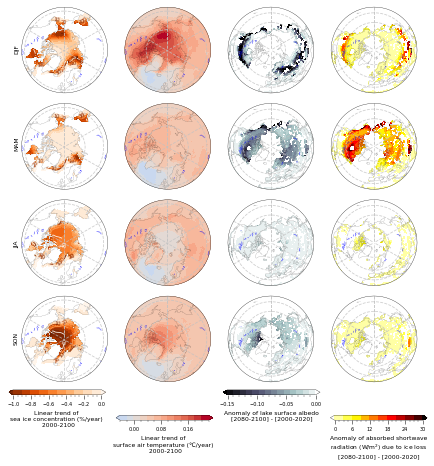

In [87]:
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(4,4,
                       figsize = (18 * cm,18 * cm),
                       subplot_kw={'projection':ccrs.Orthographic(central_latitude=90)})
plt.subplots_adjust(hspace=0)
########################################################################################################################
cmap = 'Oranges_r'
for i in np.arange(4):
        ax = axs[i,0]
        ax.set_extent([-180, 180, 45, 90], ccrs.PlateCarree())
        ax.coastlines(linewidths = 0.1)
        ax.add_feature(cf.NaturalEarthFeature('physical','lakes','110m'),
                      linewidths = 0.2,
                      facecolor = 'None',
                      edgecolor = 'blue')
        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.gridlines(crs = ccrs.PlateCarree(), 
                     linestyle='--',
                     lw = 0.8,
                     alpha = 0.8,
                     color = '#c2c2c2',
                     ylocs = (30,50,70),
                     draw_labels=False)
        cs = ax.contour(icefrac_sea_ensmean.lon,
                       icefrac_sea_ensmean.lat,
                       icefrac_sea_ensmean_clim20[i,:,:],
                       levels = [10,20,50,80],
                       cmap = cmap,
                       linewidths = 0.8,
                       transform = ccrs.PlateCarree()
                       )
        ax.clabel(cs, fontsize = 5, fmt = '%.0i')
        pl = icefrac_sea_ensmean_trend[i,:,:].plot(vmin = -1,
                                                   vmax = 0,
                                                   levels = 11,
                                                   cmap = cmap,
                                                   ax = ax,
                                                   extend = 'both',
                                                   transform = ccrs.PlateCarree(),
                                                   add_colorbar = False)
        #ax.set_title(icefrac_sea_ensmean_trend[i,0,0].time.dt.season.values)
        ax.set_title('')
        #ax.stock_img()
#************************************************************************        
cax = fig.add_axes([0.1,0.11,0.19,0.01])
cb    = fig.colorbar(pl,
                    cax = cax,
                    fraction = 0.06,
                    orientation = 'horizontal',
                    shrink = 0.8,
                    aspect   = 40,
                    )
cb.ax.minorticks_on()
cb.set_label('Linear trend of \nsea ice concentration (%/year) \n 2000-2100', fontsize =6)
cb.ax.tick_params(labelsize = 5)
cb.minorticks_on()
########################################################################################################################
cmap = plt.cm.get_cmap('coolwarm', 22)
cmap = mpl.colors.ListedColormap(cmap(np.arange(9,22)))
for i in np.arange(4):
        ax = axs[i,1]
        ax.set_extent([-180, 180, 45, 90], ccrs.PlateCarree())
        ax.coastlines(linewidths = 0.1)
        ax.add_feature(cf.NaturalEarthFeature('physical','lakes','110m'),
                      linewidths = 0.2,
                      facecolor = 'None',
                      edgecolor = 'blue')
        ax.set_boundary(circle, transform=ax.transAxes)
        pl = trefht_sea_ensmean_trend[i,:,:].plot(vmin = -0.04,
                                                  vmax = 0.22,
                                                  cmap = cmap,
                                                  levels = 14,
                                                  ax = ax,
                                                  transform = ccrs.PlateCarree(),
                                                  extend = 'both',
                                                  add_colorbar = False)
        #ax.set_title(trefht_sea_ensmean_trend[i,0,0].time.dt.season.values)
        ax.set_title('')
        ax.gridlines(crs = ccrs.PlateCarree(), 
                     linestyle='--',
                     lw = 0.8,
                     color = '#c2c2c2',
                     alpha = 0.8,
                     ylocs = (30,50,70),
                     draw_labels=False)
#************************************************************************        
cax = fig.add_axes([0.31,0.06,0.19,0.01])
cb    = fig.colorbar(pl,
                    cax = cax,
                    fraction = 0.06,
                    orientation = 'horizontal',
                    shrink = 0.8,
                    aspect   = 40,
                    ticks = [0,0.08,0.16]
                    )
cb.ax.minorticks_on()
cb.set_label('Linear trend of \nsurface air temperature (\u2103/year) \n 2000-2100', fontsize =6)
cb.ax.tick_params(labelsize = 5)
cb.minorticks_on()
########################################################################################################################
cmap = 'bone'
for i in np.arange(4):
        ax = axs[i,2]
        #ax.stock_img()
        ax.coastlines(linewidths = 0.1)
        ax.add_feature(cf.NaturalEarthFeature('physical', 'lakes', '110m'), 
                        linewidths = 0.2,
                       facecolor='None',
                       edgecolor='Blue')
        #ax.add_feature(cf.OCEAN, color = 'paleturquoise')
        #ax.add_feature(cf.LAND,color = 'silver')
        #ax.add_feature(cf.NaturalEarthFeature())
        pl = alblake_change_21cent_grid[[0,2,1,3][i],:,:].plot(vmin = -0.15, 
                                                               vmax = 0,
                                                               ax = ax,
                                                               cmap = cmap,
                                                               levels = 15,
                                                               extend = 'both',
                                                               transform = ccrs.PlateCarree(),
                                                               add_colorbar = False)

        ax.gridlines(crs = ccrs.PlateCarree(),
                      draw_labels = False,
                      alpha = 0.8,
                      color = '#c2c2c2',
                      linestyle='--',
                     lw = 0.8,
                      ylocs = (30,50,70))
        #ax.set_title(alblake_change_21cent_grid[[0,2,1,3][i],:,:].season.values)
        ax.set_title('')
#************************************************************************
cax = fig.add_axes([0.52,0.11,0.19,0.01])
cb    = fig.colorbar(pl,
                    cax = cax,
                    fraction = 0.06,
                    orientation = 'horizontal',
                    shrink = 0.8,
                    aspect   = 40,
                     ticks = [-0.15,-0.1,-0.05,0]
                    )
cb.ax.minorticks_on()
cb.set_label('Anomaly of lake surface albedo\n[2080-2100] - [2000-2020]', fontsize =6)
cb.ax.tick_params(labelsize = 5)
cb.minorticks_on()

########################################################################################################################
cmap = 'hot_r'
for i in np.arange(4):
        ax = axs[i,3]
        #ax.stock_img()
        ax.coastlines(linewidths = 0.1)
        ax.add_feature(cf.NaturalEarthFeature('physical', 'lakes', '110m'), 
                        linewidths = 0.2,
                       facecolor='None',
                       edgecolor='Blue')
        #ax.add_feature(cf.OCEAN, color = 'paleturquoise')
        #ax.add_feature(cf.LAND,color = 'silver')
        #ax.add_feature(cf.NaturalEarthFeature())
        pl = lice_fdback_sea_grid[[0,2,1,3][i],:,:].plot(vmin = 0, 
                                                         vmax = 30,
                                                         ax = ax,
                                                         levels = 11,
                                                         cmap = cmap,
                                                         extend = 'both',
                                                         transform = ccrs.PlateCarree(),
                                                         add_colorbar = False)

        ax.gridlines(crs = ccrs.PlateCarree(),
                      draw_labels = False,
                      alpha = 0.8,
                      color = '#c2c2c2',
                      linestyle='--',
                     lw = 0.8,
                      ylocs = (30,50,70))
        #ax.set_title(lice_fdback_sea_grid[[0,2,1,3][i],:,:].season.values)
        ax.set_title('')
#************************************************************************
cax = fig.add_axes([0.73,0.06,0.19,0.01])
cb    = fig.colorbar(pl,
                    cax = cax,
                    fraction = 0.06,
                    orientation = 'horizontal',
                    shrink = 0.8,
                    aspect   = 40,
                    )
cb.ax.minorticks_on()
cb.set_label('Anomaly of absorbed shortwave\nradiation (W/m$^2$) due to ice loss \n[2080-2100] - [2000-2020]', fontsize =6)
cb.ax.tick_params(labelsize = 5)
cb.minorticks_on()

########################################################################################################################
fig.text(0.11,0.78,'DJF', rotation = 90, fontsize = 6)
fig.text(0.11,0.59,'MAM', rotation = 90, fontsize = 6)
fig.text(0.11,0.4,'JJA', rotation = 90, fontsize = 6)
fig.text(0.11,0.21,'SON', rotation = 90, fontsize = 6)
########################################################################################################################
plt.savefig('.../LAKE_ICE/Fig_3.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)

# 4. Calculate monthly mean changes 

## 4.1 calculate monthly mean changes

In [58]:
trefht_mon = trefht_ds.TREFHT.sel(time = slice('2000-01-01','2100-12-31')).compute()

trefht_mon_trend = trefht_mon[:,:12,...].copy()
trefht_mon_trend[...] = nan
for i in tqdm(np.arange(12), desc = '1st loop'):
    for j in np.arange(trefht_mon.shape[0]):
        x = trefht_mon[j,trefht_mon.time.dt.month == i + 1,:,:]
        x['time'] = x.time.dt.year
        trefht_mon_trend[j,i,...] = xarray_trend(x, units = '\u2103').slope

1st loop: 100%|██████████| 12/12 [02:09<00:00, 10.81s/it]


In [59]:
fsr_lunit_mon = fsr_lunit_ds.FSR.sel(landunit=lake_idx)

fsds_mon_lunit = fsds_ds.FSDS.isel(lat = lake_jxy, lon = lake_ixy)
fsds_mon_lunit['landunit'] = np.arange(lake_ixy.shape[0])

alblake_now_mon_lunit = fsr_lunit_mon.sel(time = slice('2000-01-01','2019-12-31')) / fsds_mon_lunit.sel(time = slice('2000-01-01','2019-12-31'))
alblake_21end_mon_lunit = fsr_lunit_mon.sel(time = slice('2080-01-01','2100-12-31')) / fsds_mon_lunit.sel(time = slice('2080-01-01','2100-12-31'))
alblake_now_monmean_lunit = alblake_now_mon_lunit.groupby('time.month').mean('time')
alblake_21end_monmean_lunit = alblake_21end_mon_lunit.groupby('time.month').mean('time')

alblake_change_21cent_mon = (alblake_21end_monmean_lunit - alblake_now_monmean_lunit).compute()

alblake_change_21cent_mon_grid = fsds_ds.FSDS[:,:12,:,:].drop('time')[:,:12,...].compute().copy()
alblake_change_21cent_mon_grid[...] = nan
alblake_change_21cent_mon_grid = alblake_change_21cent_mon_grid.rename(dict(time = 'month'))
alblake_change_21cent_mon_grid['month'] = alblake_change_21cent_mon.month
for i in tqdm(np.arange(alblake_change_21cent_mon.shape[2]), desc = '1st loop'):
        alblake_change_21cent_mon_grid[:,:,lake_jxy[i], lake_ixy[i]] = alblake_change_21cent_mon[:,:,i]

/home/huanglei/usr/anaconda3/envs/pyncl/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
1st loop: 100%|██████████| 4622/4622 [00:06<00:00, 768.85it/s]


In [60]:
variables = ['SABG']
exceptcv = ['time', 'landunit', *variables]

sabg_lunit_ds = read_in(var='.SABG.', 
                       exceptcv = exceptcv,
                       domain = 'lnd/',
                       freq='month_1/',
                        stream='h2', 
                       chunks = dict(time = 40),
                       ens_s=30, ens_e=90)
sabg_lunit_mon = sabg_lunit_ds.SABG.sel(landunit=lake_idx)
fsds_now_mon_lunit = fsds_mon_lunit.sel(time=slice('2000-01-01','2019-12-31')).groupby('time.month').mean('time')
sabg_now_mon_lunit = sabg_lunit_mon.sel(time=slice('2000-01-01','2019-12-31')).groupby('time.month').mean('time')
fsds_21end_mon_lunit = fsds_mon_lunit.sel(time=slice('2080-01-01','2100-12-31')).groupby('time.month').mean('time')
sabg_21end_mon_lunit = sabg_lunit_mon.sel(time=slice('2080-01-01','2100-12-31')).groupby('time.month').mean('time')
lice_fdback_mon_lunit = ((sabg_21end_mon_lunit - sabg_now_mon_lunit) - (fsds_21end_mon_lunit - fsds_now_mon_lunit)).compute()
lice_fdback_pert_mon_lunit = (((sabg_21end_mon_lunit - sabg_now_mon_lunit) - (fsds_21end_mon_lunit - fsds_now_mon_lunit)) / sabg_now_mon_lunit).compute()

lice_fdback_mon_grid = fsds_ds.FSDS[:,:12,:,:].drop('time').compute().copy()
lice_fdback_mon_grid[...] = nan
lice_fdback_mon_grid = lice_fdback_mon_grid.rename(dict(time = 'month'))
lice_fdback_mon_grid['month'] = lice_fdback_mon_lunit.month
for i in tqdm(np.arange(lice_fdback_mon_lunit.shape[2]),desc = '1st loop'):
    lice_fdback_mon_grid[:,:,lake_jxy[i], lake_ixy[i]] = lice_fdback_mon_lunit[:,:,i]

/home/huanglei/usr/anaconda3/envs/pyncl/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
1st loop: 100%|██████████| 4622/4622 [00:06<00:00, 756.10it/s]


## 4.2 calculate mean change in the albedo and shortwave weighted by lake area in the Arctic and the Tibetan Plateau

In [64]:
area_weight = xr.open_dataset('.../b.e21.BHISTcmip6.f09_g17.LE2-1001.001.cam.h0.TREFHT.185001-185912.nc').gw # gw is the grid cell area weight
arctic_x = trefht_mon_trend.sel(lat = slice(50,90)).weighted(area_weight.sel(lat = slice(50,90)).fillna(0)).mean(('lat','lon'))
arctic_y = alblake_change_21cent_mon_grid.sel(lat = slice(50,90)).weighted(lake_area.sel(lat = slice(50,90)).fillna(0)).mean(('lat','lon'))
arctic_z = lice_fdback_mon_grid.sel(lat = slice(50,90)).weighted(lake_area.sel(lat = slice(50,90)).fillna(0)).mean(('lat','lon'))

tp_x = trefht_mon_trend.sel(lat = slice(28,38), lon = slice(70, 100)).weighted(area_weight.sel(lat = slice(28,38))).mean(('lat','lon'))
tp_y = alblake_change_21cent_mon_grid.sel(lat = slice(28,38), lon = slice(70, 100)).weighted(lake_area.sel(lat = slice(28,38), lon = slice(70, 100)).fillna(0)).mean(('lat','lon'))                                                                               
tp_z = lice_fdback_mon_grid.sel(lat = slice(28,38), lon = slice(70, 100)).weighted(lake_area.sel(lat = slice(28,38), lon = slice(70, 100)).fillna(0)).mean(('lat','lon'))

In [65]:
arctic_x = xr.concat([arctic_x[:,-6:],arctic_x[:,:6]],dim='time')
arctic_x['time'] = np.arange(1,13)
arctic_y = xr.concat([arctic_y[:,-6:],arctic_y[:,:6]],dim='month')
arctic_y['month'] = np.arange(1,13)
arctic_z = xr.concat([arctic_z[:,-6:],arctic_z[:,:6]],dim='month')
arctic_z['month'] = np.arange(1,13)
tp_x = xr.concat([tp_x[:,-6:],tp_x[:,:6]],dim='time')
tp_x['time'] = np.arange(1,13)
tp_y = xr.concat([tp_y[:,-6:],tp_y[:,:6]],dim='month')
tp_y['month'] = np.arange(1,13)
tp_z = xr.concat([tp_z[:,-6:],tp_z[:,:6]],dim='month')
tp_z['month'] = np.arange(1,13)

# 5. plot Figure 4

In [61]:
# import the schematic diagram drawn by hand
im = plt.imread('.../lake ice scheme.png')

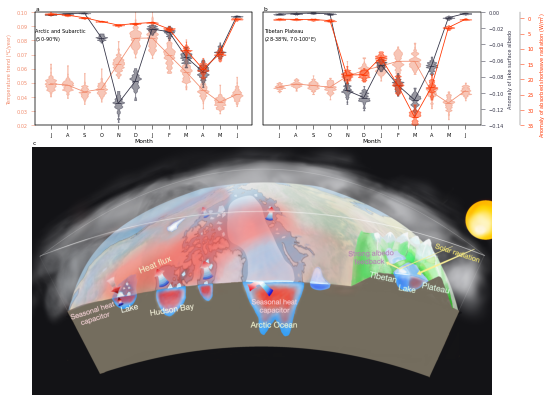

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [86]:
cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(3,2, figsize = (18 * cm,18* cm))
fig.subplots_adjust(right=1)
fig.subplots_adjust(wspace=0.05)
ax1 = axs[0,0]
ax2 = axs[0,1]
twin1 = ax1.twinx()
twin2 = ax1.twinx()
twin3 = ax2.twinx()
twin4 = ax2.twinx()
colr1 = plt.cm.get_cmap('coolwarm',10)(7)#'#1f77b4'
colr2 = plt.cm.get_cmap('bone',10)(2)#'#ff7f0e'
colr3 = plt.cm.get_cmap('hot_r',10)(5)#'#2ca02c'
month = ['J','A','S','O','N','D','J','F','M','A','M','J']
####################################################################################
#plot the Arctic

#------------------------------------------------------------------------------------
p1 = ax1.violinplot(arctic_x,
              showmeans = True,
               showmedians=False,
              widths=0.7,
              showextrema=False,
              bw_method=0.1)
p1['cmeans'].set_color(colr1)
p1['cmeans'].set_linewidth(0.8)
for pc in p1['bodies']:
    pc.set_facecolor(colr1)
    pc.set_edgecolor(colr1)
    pc.set_linewidth(0.8)
    pc.set_alpha(0.5)
    
ax1.plot(arctic_x.time,
       arctic_x.mean('ensemble'),
       c = colr1,
        lw = 0.8)
#------------------------------------------------------------------------------------
p2 = twin1.violinplot(arctic_y,
              showmeans = True,
               showmedians=False,
              widths=0.7,
              showextrema=False,
              bw_method=0.1)
p2['cmeans'].set_color(colr2)
p2['cmeans'].set_linewidth(0.8)
for pc in p2['bodies']:
    pc.set_facecolor(colr2)
    pc.set_edgecolor(colr2)
    pc.set_linewidth(0.8)
    pc.set_alpha(0.5)

twin1.plot(arctic_y.month,
       arctic_y.mean('ensemble'),
       c = colr2,
          lw = 0.8)
#------------------------------------------------------------------------------------
p3 = twin2.violinplot(arctic_z,
              showmeans = True,
               showmedians=False,
              widths=0.7,
              showextrema=False,
              bw_method=0.1)
p3['cmeans'].set_color(colr3)
p3['cmeans'].set_linewidth(0.8)
for pc in p3['bodies']:
    pc.set_facecolor(colr3)
    pc.set_edgecolor(colr3)
    pc.set_linewidth(0.8)
    pc.set_alpha(0.5)

twin2.plot(arctic_z.month,
       arctic_z.mean('ensemble'),
       c = colr3,
        lw = 0.8)
#------------------------------------------------------------------------------------
ax1.set_xticks(np.arange(1,13))
ax1.set_xticklabels(month)
ax1.set_ylim(0.02, 0.1)
twin1.yaxis.set_visible(False)
twin2.yaxis.set_visible(False)
twin1.sharey(twin3)
twin2.sharey(twin4)


ax1.set_xlabel("Month", fontsize = 6, labelpad = 0.8)
ax1.set_ylabel("Temperature trend (\u2103/year)")

ax1.yaxis.label.set_color(colr1)

tkw = dict(size=4, length = 2)
ax1.tick_params(axis='y', colors=colr1, **tkw)
ax1.tick_params(axis='x', **tkw)

ax1.text(0.1,0.08,'Arctic and Subarctic\n(50-90$\degree$N)')

####################################################################################
#plot the TP

# Offset the right spine of twin4.  The ticks and label have already been
# placed on the right by twinx above.
twin4.spines["right"].set_position(("axes", 1.18))
#------------------------------------------------------------------------------------
p4 = ax2.violinplot(tp_x,
              showmeans = True,
               showmedians=False,
              widths=0.7,
              showextrema=False,
              bw_method=0.1)
p4['cmeans'].set_color(colr1)
p4['cmeans'].set_linewidth(0.8)
for pc in p4['bodies']:
    pc.set_facecolor(colr1)
    pc.set_edgecolor(colr1)
    pc.set_linewidth(0.8)
    pc.set_alpha(0.5)
    
ax2.plot(tp_x.time,
       tp_x.mean('ensemble'),
       c = colr1,
        lw = 0.8)
#------------------------------------------------------------------------------------
p5 = twin3.violinplot(tp_y,
              showmeans = True,
               showmedians=False,
              widths=0.7,
              showextrema=False,
              bw_method=0.1)
p5['cmeans'].set_color(colr2)
p5['cmeans'].set_linewidth(0.8)
for pc in p5['bodies']:
    pc.set_facecolor(colr2)
    pc.set_edgecolor(colr2)
    pc.set_linewidth(0.8)
    pc.set_alpha(0.5)

twin3.plot(tp_y.month,
       tp_y.mean('ensemble'),
       c = colr2,
        lw = 0.8)
#------------------------------------------------------------------------------------
p6 = twin4.violinplot(tp_z,
              showmeans = True,
               showmedians=False,
              widths=0.7,
              showextrema=False,
              bw_method=0.1)
p6['cmeans'].set_color(colr3)
p6['cmeans'].set_linewidth(0.8)
for pc in p6['bodies']:
    pc.set_facecolor(colr3)
    pc.set_edgecolor(colr3)
    pc.set_linewidth(0.8)
    pc.set_alpha(0.5)

twin4.plot(tp_z.month,
       tp_z.mean('ensemble'),
       c = colr3,
        lw = 0.8)
#------------------------------------------------------------------------------------
#ax.set_xlim(0, 2)
ax2.sharex(ax1)
ax2.sharey(ax1)
twin3.set_ylim(-0.14, 0)
twin4.set_ylim(-2, 35)
ax2.yaxis.set_visible(False)
twin4.invert_yaxis()

ax2.set_xlabel('Month', fontsize = 6, labelpad = 0.8)
twin3.set_ylabel("Anomaly of lake surface albedo")
twin4.set_ylabel("Anomaly of absorbed shortwave radiation (W/m$^2$)", loc = 'top')

twin3.yaxis.label.set_color(colr2)
twin4.yaxis.label.set_color(colr3)

tkw = dict(size=4, length = 2)
twin3.tick_params(axis='y', colors=colr2, **tkw)
twin4.tick_params(axis='y', colors=colr3, **tkw)

ax2.text(0.1,0.08, 'Tibetan Plateau\n(28-38$\degree$N, 70-100$\degree$E)')
ax2.text(0.1,0.101,'b', fontsize = 6)
ax1.text(0.1,0.101,'a', fontsize = 6)
####################################################################################
#insert the schematic map
[ax.remove() for ax in fig.axes[2:6]]
imax = fig.add_axes([0.12,0.13,0.9, 0.9*(im.shape[0]/im.shape[1])])
imax.imshow(im)
imax.axis('off')
fig.text(0.12,0.62,'c', fontsize = 6)
########################################################################################################################
plt.savefig('.../Fig_4.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close(fig)